In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import model_selection, preprocessing
import xgboost as xgb
import datetime
import math

pd.options.display.max_columns = 300
%matplotlib inline  

/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [26]:
df_train = pd.read_csv('train.csv', parse_dates=['timestamp'])
df_test = pd.read_csv('test.csv', parse_dates=['timestamp'])
df_macro = pd.read_csv('macro.csv', parse_dates=['timestamp'])
id_test = df_test.id
df_train.sample(3)

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

In [27]:
df_train.shape, df_test.shape

((30471, 292), (7662, 291))

In [28]:
df_macro = df_macro.drop(['child_on_acc_pre_school'], axis=1)

In [29]:
df_train = pd.merge_ordered(df_train, df_macro, on='timestamp', how='left')
df_test = pd.merge_ordered(df_test, df_macro, on='timestamp', how='left')
df_train.shape, df_test.shape

((30471, 390), (7662, 389))

In [30]:
df_train.sample(3)

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,...,church_count_2000,mosque_count_2000,leisure_count_2000,sport_count_2000,market_count_2000,green_part_3000,prom_part_3000,office_count_3000,office_sqm_3000,trc_count_3000,trc_sqm_3000,cafe_count_3000,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,eurrub,brent,net_capital_export,gdp_annual,gdp_annual_growth,average_provision_of_build_contract,average_provision_of_build_contract_moscow,rts,micex,micex_rgbi_tr,micex_cbi_tr,deposits_value,deposits_growth,deposits_rate,mortgage_value,mortgage_growth,mortgage_rate,grp,grp_growth,income_per_cap,real_dispos_income_per_cap_growth,salary,salary_growth,fixed_basket,retail_trade_turnover,retail_trade_turnover_per_cap,retail_trade_turnover_growth,labor_f

In [40]:
y_train = df_train["price_doc"]
x_train = df_train.drop(["id", "timestamp", "price_doc"], axis=1)
x_test = df_test.drop(["id", "timestamp"], axis=1)

#can't merge train with test because the kernel run for very long time

for c in x_train.columns:
    if x_train[c].dtype == 'object':
#         print 'train', c
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_train[c].values)) 
        x_train[c] = lbl.transform(list(x_train[c].values))
        #x_train.drop(c,axis=1,inplace=True)
        
for c in x_test.columns:
    if x_test[c].dtype == 'object':
#         print 'test', c
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_test[c].values)) 
        x_test[c] = lbl.transform(list(x_test[c].values))
        #x_test.drop(c,axis=1,inplace=True)   

In [41]:
# Train/Valid split
split = 25000
x_tr, y_tr, x_val, y_val = x_train[:split], y_train[:split], x_train[split:], y_train[split:]

In [42]:
dtrain = xgb.DMatrix(x_tr, label=y_tr)
dval = xgb.DMatrix(x_val, label=y_val)
dtest = xgb.DMatrix(x_test)

In [99]:
def rmsle_XGB(preds, dtrain):
    labels = dtrain.get_label()
    assert len(preds) == len(labels)
    labels = labels.tolist()
    preds = preds.tolist()
    terms_to_sum = [(math.log(labels[i] + 1) - math.log(max(0, preds[i]) + 1)) ** 2.0 for i in range(len(labels))]
    return 'rmsle', (sum(terms_to_sum) * (1.0 / len(preds))) ** 0.5

In [100]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 8,
    'min_child_weight' : 0.02,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
#     'eval_metric': 'rmse',
    'silent': 1
}
# xgb_params = {
#     'eta': 0.05,
#     'max_depth': 5,
#     'subsample': 0.7,
#     'colsample_bytree': 0.7,
#     'objective': 'reg:linear',
# #     'eval_metric': 'rmse',
#     'silent': 1
# }

# evallist  = [(dval,'eval')]#, (dtrain,'train')]
num_boost_round=3000

In [101]:
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=num_boost_round, early_stopping_rounds=20,
    verbose_eval=10, show_stdv=False, feval=rmsle_XGB, nfold=5,n)
# cv_output = xgb.train(xgb_params, dtrain, num_boost_round, evallist, early_stopping_rounds=20,
#     verbose_eval=50, feval=rmsle_XGB)
# cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()
# [72]	train-rmsle:0.462161	test-rmsle:0.4756

[0]	train-rmsle:2.29025	test-rmsle:2.3023
[10]	train-rmsle:0.53221	test-rmsle:0.564155
[20]	train-rmsle:0.432284	test-rmsle:0.479402
[30]	train-rmsle:0.422572	test-rmsle:0.47828
[40]	train-rmsle:0.416025	test-rmsle:0.479869


In [ ]:
cv_output[['train-rmsle-mean', 'test-rmsle-mean']].plot()

In [34]:
num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)

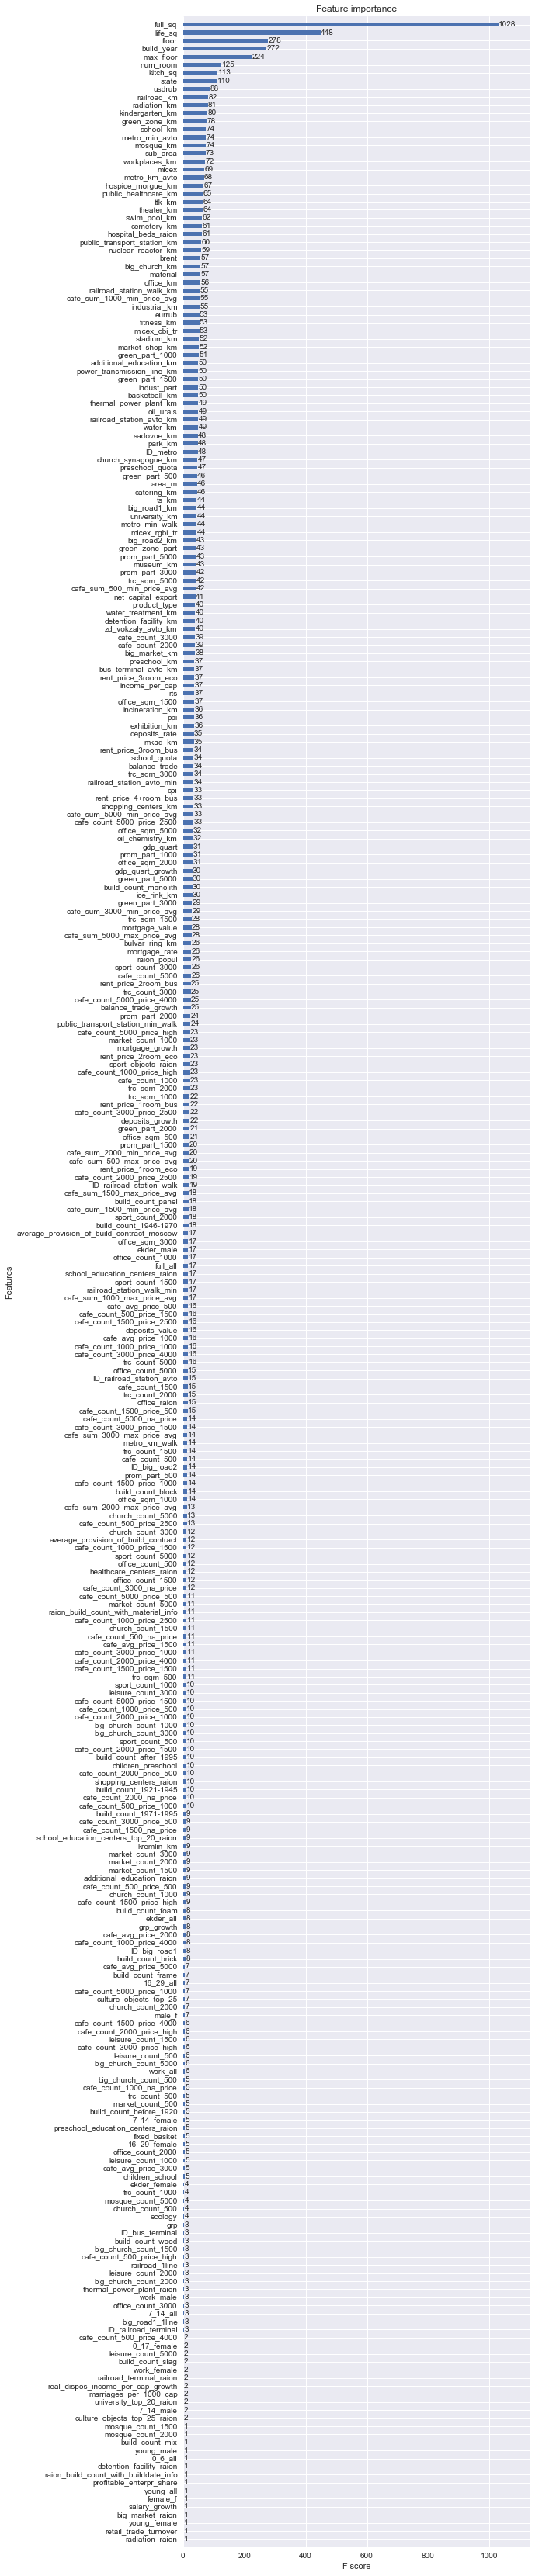

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(8, 60))
xgb.plot_importance(model, height=0.5, ax=ax)

In [37]:
y_pred = model.predict(dtrain)
print 'Train:', rmsle_XGB(y_pred, y_train)

# y_pred = model.predict(dval)
# print 'Validation:', rmsle_XGB(y_pred, y_val)
# Train: ('rmsle', 0.4658051740729287)
# Train: ('rmsle', 0.4310382028444032)

Train: ('rmsle', 0.4310382028444032)


In [38]:
y_predict = model.predict(dtest)
output = pd.DataFrame({'id': id_test, 'price_doc': y_predict})
output.head()

,id,price_doc
0,30474,5675731.5
1,30475,8570520.0
2,30476,5589299.0
3,30477,6197580.5
4,30478,5405778.0


In [39]:
output.to_csv('submissions/xgb4.csv', index=False)